
Analyzing: wn_step_0_R_initial_dim128.raw
  Loaded wn_step_0_R_initial_dim128.raw, shape: (128, 128, 128), dtype: float32
  Stats - Min: -5.054e+00, Max: 5.178e+00, Mean: 8.666e-04, Std: 9.994e-01
  Energy Ratios for R_initial: Low=0.3%, Mid=6.6%, High=93.1%

Analyzing: wn_step_1_R_ds_us_x_dim128.raw
  Loaded wn_step_1_R_ds_us_x_dim128.raw, shape: (128, 128, 128), dtype: float32
  Stats - Min: -3.327e+00, Max: 3.510e+00, Mean: 8.666e-04, Std: 7.089e-01
  Energy Ratios for R_ds_us_x: Low=0.7%, Mid=12.8%, High=86.5%

Analyzing: wn_step_2_R_ds_us_xy_dim128.raw
  Loaded wn_step_2_R_ds_us_xy_dim128.raw, shape: (128, 128, 128), dtype: float32
  Stats - Min: -2.548e+00, Max: 2.672e+00, Mean: 8.666e-04, Std: 5.022e-01
  Energy Ratios for R_ds_us_xy: Low=1.3%, Mid=24.9%, High=73.8%

Analyzing: wn_step_3_R_ds_us_xyz_dim128.raw
  Loaded wn_step_3_R_ds_us_xyz_dim128.raw, shape: (128, 128, 128), dtype: float32
  Stats - Min: -1.885e+00, Max: 1.744e+00, Mean: 8.666e-04, Std: 3.561e-01
  Energy Rati

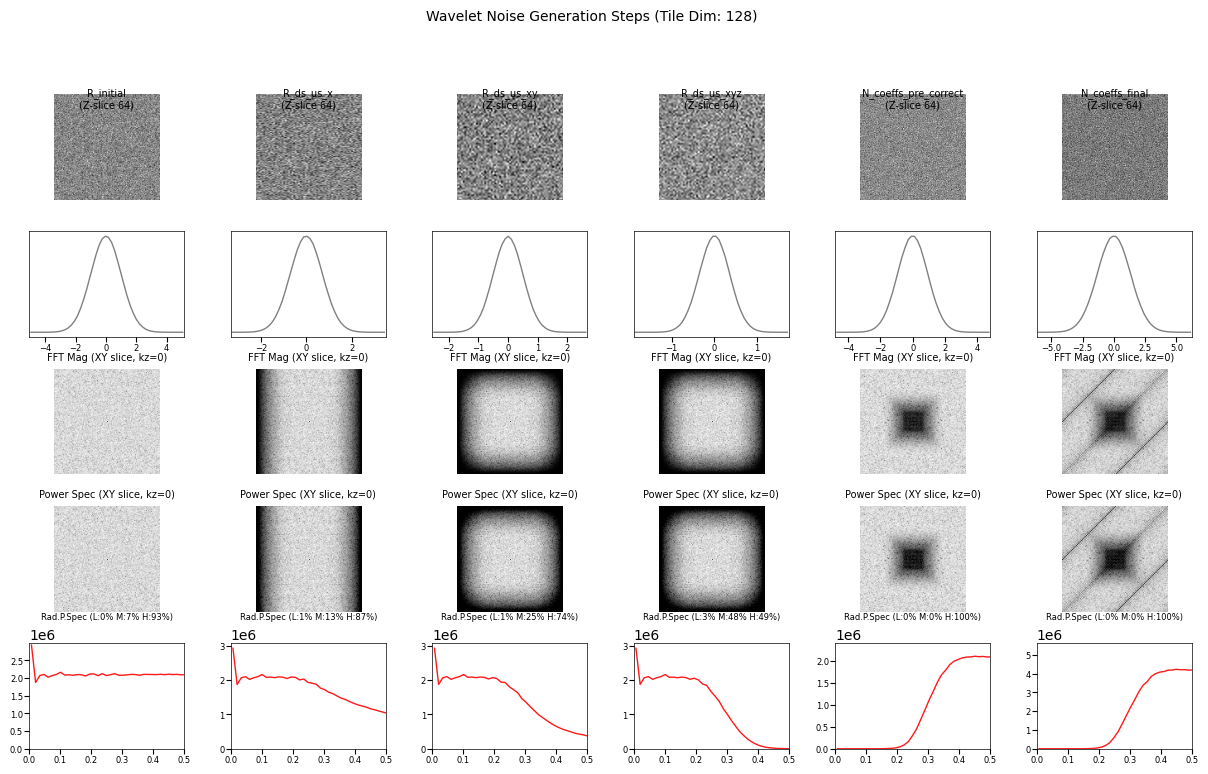

In [9]:

import numpy as np
import matplotlib.pyplot as plt
import os # For file operations
from scipy.fft import fftn, fftshift # For 3D FFT

# --- Plotting Function (adapted for multiple columns) ---
def plot_noise_analysis(noise_array, frequency_multiplier_title, fig_axs_column):
    axs = fig_axs_column

    # Row 1: Noise Image
    display_noise_image = (noise_array - np.min(noise_array)) / (np.max(noise_array) - np.min(noise_array))
    axs[0].imshow(display_noise_image, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"Freq. x{frequency_multiplier_title}", fontsize=8, y=1.0, pad=-12)

    # Row 2: Intensity Distribution
    intensity_values_raw = noise_array.flatten()
    # Single octave Perlin output is roughly in [-0.7, 0.7]
    hist_range = (-1, 1)
    intensity_values_clamped = np.clip(intensity_values_raw, hist_range[0], hist_range[1])
    hist_raw, bin_edges_raw = np.histogram(intensity_values_clamped, bins=30, range=hist_range, density=True)
    bin_centers_raw = (bin_edges_raw[:-1] + bin_edges_raw[1:]) / 2
    axs[1].plot(bin_centers_raw, hist_raw, color='gray', linewidth=1)
    axs[1].set_xlim(hist_range[0], hist_range[1])

    # Row 3: Fourier Transform Magnitude
    noise_for_fft = noise_array - np.mean(noise_array)
    F = np.fft.fft2(noise_for_fft)
    F_shifted = np.fft.fftshift(F)
    F_magnitude = np.abs(F_shifted)
    vmax_fft = np.percentile(F_magnitude[F_magnitude > 0], 98) if np.any(F_magnitude > 0) else 1
    axs[2].imshow(F_magnitude, cmap='gray', vmin=0, vmax=vmax_fft * 0.5)

    # Row 4: Power Spectrum
    power_spectrum = F_magnitude**2
    vmax_ps = np.percentile(power_spectrum[power_spectrum > 0], 98) if np.any(power_spectrum > 0) else 1
    axs[3].imshow(power_spectrum, cmap='gray', vmin=0, vmax=vmax_ps * 0.3)

    # Row 5: Radial Power Spectrum
    IMG_SIZE_local = noise_array.shape[0]
    center_x, center_y = IMG_SIZE_local // 2, IMG_SIZE_local // 2
    y_idx, x_idx = np.indices((IMG_SIZE_local, IMG_SIZE_local))
    r = np.sqrt((x_idx - center_x)**2 + (y_idx - center_y)**2)

    max_k_radius_pixels = IMG_SIZE_local // 2
    num_radial_bins = max_k_radius_pixels
    radial_bin_edges = np.arange(num_radial_bins + 1)
    radial_power = np.zeros(num_radial_bins)
    radial_freq_axis_pixels = radial_bin_edges[:-1] + 0.5

    for k_bin_idx in range(num_radial_bins):
        lower_r = radial_bin_edges[k_bin_idx]
        upper_r = radial_bin_edges[k_bin_idx+1]
        mask = (r >= lower_r) & (r < upper_r)
        values_in_bin = power_spectrum[mask]
        if len(values_in_bin) > 0:
            radial_power[k_bin_idx] = np.mean(values_in_bin)
        else:
            radial_power[k_bin_idx] = 0

    radial_freq_axis_normalized_plot = radial_freq_axis_pixels / IMG_SIZE_local
    axs[4].plot(radial_freq_axis_normalized_plot, radial_power, color='red', alpha=0.9, linewidth=1)
    axs[4].set_xlim(0, 0.5)
    axs[4].set_ylim(bottom=0)

    # Optional: Scale Y-axis for the first column (freq_multiplier=1) to match paper's Perlin
    if frequency_multiplier_title == 1 and np.max(radial_power) > 0:
        max_val_paper_perlin_radial = 0.12
        current_max_val = np.max(radial_power)
        scaling_factor = max_val_paper_perlin_radial / current_max_val if current_max_val > 0 else 1.0
        axs[4].clear()
        axs[4].plot(radial_freq_axis_normalized_plot, radial_power * scaling_factor, color='red', alpha=0.9, linewidth=1)
        axs[4].set_ylim(0, max_val_paper_perlin_radial * 1.1)
        axs[4].set_xlim(0, 0.5)


    # Common subplot styling
    for i, ax_h in enumerate(axs):
        if i not in [1, 4]:
            ax_h.axis('off')
        else:
            ax_h.tick_params(axis='x', labelsize=6, pad=1)
            ax_h.tick_params(axis='y', labelsize=6, pad=1)
            if i == 1: ax_h.set_yticks([])
        ax_h.set_frame_on(True)
        for spine in ax_h.spines.values():
            spine.set_edgecolor('black'); spine.set_linewidth(0.5)

# --- Plotting Function (modified to handle 3D data and show slices for FFT) ---
def plot_3d_noise_analysis(data_3d, title_prefix, fig_axs_column):
    axs = fig_axs_column
    dim_n = data_3d.shape[0]

    # --- Row 1: Noise Image (show a middle slice) ---
    slice_idx = dim_n // 2
    noise_slice_2d = data_3d[slice_idx, :, :].copy() # Z-slice

    display_min = np.min(noise_slice_2d)
    display_max = np.max(noise_slice_2d)
    display_range = display_max - display_min
    if display_range < 1e-9:
        display_noise_image = np.full_like(noise_slice_2d, 0.5)
    else:
        display_noise_image = (noise_slice_2d - display_min) / display_range
    
    axs[0].imshow(display_noise_image, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"{title_prefix}\n(Z-slice {slice_idx})", fontsize=7, y=1.0, pad=-10)

    # --- Row 2: Intensity Distribution (from full 3D data) ---
    intensity_values_raw = data_3d.flatten()
    current_min_intensity = np.min(intensity_values_raw)
    current_max_intensity = np.max(intensity_values_raw)
    if current_max_intensity - current_min_intensity < 1e-6:
        current_min_intensity -= 0.5; current_max_intensity += 0.5
    
    hist_raw, bin_edges_raw = np.histogram(intensity_values_raw, bins=50, 
                                           range=(current_min_intensity, current_max_intensity), 
                                           density=True)
    bin_centers_raw = (bin_edges_raw[:-1] + bin_edges_raw[1:]) / 2
    axs[1].plot(bin_centers_raw, hist_raw, color='gray', linewidth=1)
    axs[1].set_xlim(current_min_intensity, current_max_intensity)

    # --- Row 3: Fourier Transform Magnitude (XY slice at kz=0 of 3D FFT) ---
    data_for_fft = data_3d - np.mean(data_3d)
    F_3d = fftshift(fftn(data_for_fft)) # Centered 3D FFT
    F_magnitude_3d = np.abs(F_3d)
    
    # Show XY slice at kz=0 (center slice in frequency domain)
    kz0_slice_idx = F_magnitude_3d.shape[0] // 2 
    F_magnitude_xy_slice = F_magnitude_3d[kz0_slice_idx, :, :]
    axs[2].imshow(np.log1p(F_magnitude_xy_slice), cmap='gray')
    axs[2].set_title("FFT Mag (XY slice, kz=0)", fontsize=7)


    # --- Row 4: Power Spectrum (XY slice at kz=0 of 3D Power Spectrum) ---
    power_spectrum_3d = F_magnitude_3d**2
    power_spectrum_xy_slice = power_spectrum_3d[kz0_slice_idx, :, :]
    axs[3].imshow(np.log1p(power_spectrum_xy_slice), cmap='gray')
    axs[3].set_title("Power Spec (XY slice, kz=0)", fontsize=7)

    # --- Row 5: Radial Power Spectrum (from 3D Power Spectrum) ---
    # Calculate 3D radial average
    center_z, center_y, center_x = [d // 2 for d in power_spectrum_3d.shape]
    z_idx, y_idx, x_idx = np.indices(power_spectrum_3d.shape)
    r_3d = np.sqrt((x_idx - center_x)**2 + (y_idx - center_y)**2 + (z_idx - center_z)**2)

    max_k_radius_pixels_3d = int(np.sqrt(center_x**2 + center_y**2 + center_z**2))
    # Or simply: max_k_radius_pixels_3d = dim_n // 2 (approx for Nyquist)
    
    num_radial_bins_3d = dim_n // 2 # Use a consistent number of bins
    radial_bin_edges_3d = np.linspace(0, max_k_radius_pixels_3d, num_radial_bins_3d + 1)
    radial_power_3d = np.zeros(num_radial_bins_3d)
    bin_counts_3d = np.zeros(num_radial_bins_3d, dtype=int)

    for k_bin_idx in range(num_radial_bins_3d):
        lower_r = radial_bin_edges_3d[k_bin_idx]
        upper_r = radial_bin_edges_3d[k_bin_idx+1]
        mask = (r_3d >= lower_r) & (r_3d < upper_r)
        values_in_bin = power_spectrum_3d[mask]
        if len(values_in_bin) > 0:
            radial_power_3d[k_bin_idx] = np.mean(values_in_bin)
            bin_counts_3d[k_bin_idx] = len(values_in_bin)

    # Normalize frequency axis for plotting: k_norm = k_pixels / (dim_n) -> Nyquist at 0.5
    radial_freq_axis_pixels_3d = (radial_bin_edges_3d[:-1] + radial_bin_edges_3d[1:]) / 2.0
    radial_freq_axis_normalized_plot_3d = radial_freq_axis_pixels_3d / dim_n
    
    axs[4].plot(radial_freq_axis_normalized_plot_3d, radial_power_3d, color='red', alpha=0.9, linewidth=1)
    axs[4].set_xlim(0, 0.5)
    axs[4].set_ylim(bottom=0)
    
    # --- Frequency Band Energy Ratios ---
    total_spectral_energy = np.sum(radial_power_3d * bin_counts_3d) # Weighted by number of points in shell
    if total_spectral_energy < 1e-9: total_spectral_energy = 1.0 # Avoid div by zero

    # Define frequency bands (normalized frequency [0, 0.5])
    # These are illustrative, adjust as needed
    low_freq_cutoff = 0.1  # e.g., 0 to 0.1
    mid_freq_cutoff = 0.25 # e.g., 0.1 to 0.25
    # High freq is > 0.25

    energy_low = 0
    energy_mid = 0
    energy_high = 0

    for i in range(len(radial_power_3d)):
        freq_norm = radial_freq_axis_normalized_plot_3d[i]
        power_in_shell = radial_power_3d[i] * bin_counts_3d[i]
        if freq_norm < low_freq_cutoff:
            energy_low += power_in_shell
        elif freq_norm < mid_freq_cutoff:
            energy_mid += power_in_shell
        else:
            energy_high += power_in_shell
            
    ratio_low = energy_low / total_spectral_energy
    ratio_mid = energy_mid / total_spectral_energy
    ratio_high = energy_high / total_spectral_energy
    
    print(f"  Energy Ratios for {title_prefix}: Low={ratio_low*100:.1f}%, Mid={ratio_mid*100:.1f}%, High={ratio_high*100:.1f}%")
    axs[4].set_title(f"Rad.P.Spec (L:{ratio_low*100:.0f}% M:{ratio_mid*100:.0f}% H:{ratio_high*100:.0f}%)", fontsize=6)


    # Common subplot styling
    for i, ax_h in enumerate(axs):
        if i not in [1, 4]: 
            ax_h.axis('off')
        else:
            ax_h.tick_params(axis='x', labelsize=6, pad=1)
            ax_h.tick_params(axis='y', labelsize=6, pad=1)
            if i == 1: ax_h.set_yticks([])
        ax_h.set_frame_on(True)
        for spine in ax_h.spines.values():
            spine.set_edgecolor('black'); spine.set_linewidth(0.5)


if __name__ == "__main__":

    cpp_tile_size_param = 128 # The parameter given to WaveletNoise constructor in C++
    dim_n_cpp = cpp_tile_size_param + (1 if cpp_tile_size_param % 2 != 0 else 0)

    raw_file_base = "wn_step_"
    steps_to_analyze = [
        "0_R_initial",
        "1_R_ds_us_x",
        "2_R_ds_us_xy",
        "3_R_ds_us_xyz",
        "4_N_coeffs_pre_correct",
        "5_N_coeffs_final"
    ]

    num_steps = len(steps_to_analyze)
    fig_all_steps, all_axs = plt.subplots(5, num_steps, figsize=(num_steps * 2.5, 8.5), squeeze=False)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


    for idx, step_name in enumerate(steps_to_analyze):
        filename = f"{raw_file_base}{step_name}_dim{dim_n_cpp}.raw"
        print(f"\nAnalyzing: {filename}")

        try:
            with open(filename, 'rb') as f:
                raw_data_bytes = f.read()
            
            data_flat = np.frombuffer(raw_data_bytes, dtype=np.float32)
            
            expected_elements = dim_n_cpp * dim_n_cpp * dim_n_cpp
            if data_flat.size != expected_elements:
                raise ValueError(f"Data size mismatch for {filename}: expected {expected_elements}, got {data_flat.size}")

            data_3d_cube = data_flat.reshape((dim_n_cpp, dim_n_cpp, dim_n_cpp)) # Assuming Z, Y, X order from C++ loops
            
            print(f"  Loaded {filename}, shape: {data_3d_cube.shape}, dtype: {data_3d_cube.dtype}")
            print(f"  Stats - Min: {np.min(data_3d_cube):.3e}, Max: {np.max(data_3d_cube):.3e}, Mean: {np.mean(data_3d_cube):.3e}, Std: {np.std(data_3d_cube):.3e}")

            current_axs_column = all_axs[:, idx]
            plot_3d_noise_analysis(data_3d_cube, step_name.split('_',1)[1], current_axs_column)
            
        except FileNotFoundError:
            print(f"  Error: File '{filename}' not found.")
        except ValueError as ve:
            print(f"  ValueError: {ve}")
        except Exception as e:
            print(f"  An error occurred processing {filename}: {e}")

    # Also analyze the final evaluated image from C++ main.cpp (if generated)
    cpp_evaluated_image_file = "wavelet_noise_cpp_output.raw"
    VIZ_SIZE_CPP = 256 # Must match C++ main.cpp VIZ_SIZE

    try:
        print(f"\nAnalyzing final evaluated image: {cpp_evaluated_image_file}")
        with open(cpp_evaluated_image_file, 'rb') as f:
            raw_data_eval_bytes = f.read()
        data_eval_flat = np.frombuffer(raw_data_eval_bytes, dtype=np.float32)
        if data_eval_flat.size != VIZ_SIZE_CPP * VIZ_SIZE_CPP:
            raise ValueError("Size mismatch for final evaluated image.")
        
        evaluated_image_2d = data_eval_flat.reshape((VIZ_SIZE_CPP, VIZ_SIZE_CPP))
        print(f"  Loaded {cpp_evaluated_image_file}, shape: {evaluated_image_2d.shape}, dtype: {evaluated_image_2d.dtype}")
        print(f"  Stats - Min: {np.min(evaluated_image_2d):.3e}, Max: {np.max(evaluated_image_2d):.3e}, Mean: {np.mean(evaluated_image_2d):.3e}, Std: {np.std(evaluated_image_2d):.3e}")

        # Need to use the 2D plotting function for this one or adapt plot_3d_noise_analysis
        # For simplicity, let's create a new figure for it using a 2D analysis function.
        # Reusing the old `plot_noise_analysis` for 2D data:
        fig_eval, axs_eval_col = plt.subplots(5, 1, figsize=(3.0, 9.0), squeeze=False)
        plot_noise_analysis(evaluated_image_2d, "Final C++ Eval Img", axs_eval_col[:,0])
        fig_eval.tight_layout(pad=0.2, h_pad=0.1, w_pad=0.1)
        fig_eval.subplots_adjust(hspace=0.15)
        fig_eval.savefig("analysis_of_cpp_final_eval_image.png", dpi=150)
        print(f"  Saved analysis of final evaluated image.")


    except FileNotFoundError:
        print(f"  Final evaluated image '{cpp_evaluated_image_file}' not found.")
    except Exception as e:
        print(f"  Error processing final evaluated image: {e}")


    fig_all_steps.suptitle(f"Wavelet Noise Generation Steps (Tile Dim: {dim_n_cpp})", fontsize=10)
    fig_all_steps.savefig(f"analysis_of_cpp_wavelet_steps_dim{dim_n_cpp}.png", dpi=120)
    plt.show()